# FUNDAMENTO TEÓRICO

Sea $x \in \mathbb{R}$ una muestra de señal analógica. Se define un conjunto finito de niveles de cuantificación:

$$
C = \{ y_1, y_2, \dots, y_L \}
$$

donde cada $y_k$ es un valor que representará una región particular del espacio de entrada. Para determinar estas regiones, se define un conjunto de umbrales de decisión:
$$
U = \{ u_0, u_1, \dots, u_L \}, \quad \text{con } u_0 < u_1 < \dots < u_L
$$
que delimita los bordes de cada intervalo. Cada intervalo $R_k$, denominado región de cuantificación, se define como:
$$
R_k = \{ x \in \mathbb{R} : u_{k-1} < x \leq u_k \}
$$
para $k = 1, 2, \dots, L$. Esto implica que si un valor de entrada $x$ cae dentro del intervalo $R_k$, se le asignará el valor $y_k$. La operación de cuantificación se define entonces como una función $Q : \mathbb{R} \to C$, tal que:
$$
Q(x) = y_k \qquad \text{si y solo si } \quad u_{k-1} < x \leq u_k
$$
Esta función reemplaza cada valor continuo de entrada por el valor discreto más cercano según la partición definida por los umbrales.
___


Sea $C = \{y_1, y_2, \dots, y_L\}$ el conjunto de niveles de cuantificación, y $U = \{u_0, u_1, \dots, u_L\}$ el conjunto de umbrales de decisión que determinan las regiones de cuantificación $R_k = (u_{k-1}, u_k]$. Para cada región $R_k$, el nivel $y_k$ representa el valor asignado a todas las entradas $x$ que caen dentro de dicha región. El error de cuantificación se define como la diferencia entre el valor original $x$ y su nivel cuantificado $y_k$, y el error cuadrático medio total se expresa como:

$$
\sigma_e^2 = \sum_{k=1}^L \int_{u_{k-1}}^{u_k} (x - y_k)^2 p_X(x) \, dx
$$

Este funcional depende simultáneamente de dos tipos de variables: los umbrales $u_k$ y los niveles $y_k$. Minimizar $\sigma_e^2$ implica resolver un problema de optimización sobre múltiples variables acopladas. Dado que no existe una solución cerrada directa para este caso general, se recurre a una estrategia de optimización alternada: se fija uno de los dos conjuntos de variables y se optimiza con respecto al otro.

Cuando se fija el conjunto de niveles $\{y_k\}$, se puede derivar la expresión óptima para los umbrales de decisión. La condición necesaria de optimalidad consiste en que la derivada parcial de $\sigma_e^2$ respecto a cada umbral $u_k$ sea nula. Considerando que $y_k$ y $y_{k+1}$ son constantes, y que $u_k$ aparece como límite superior de $R_k$ y como límite inferior de $R_{k+1}$, la derivada parcial conduce a la igualdad:

$$
\frac{\partial \sigma_e^2}{\partial u_k} = 0 \quad \Rightarrow \quad u_k = \frac{y_k + y_{k+1}}{2}
$$

Este resultado tiene una interpretación geométrica clara: el umbral óptimo entre dos niveles debe ubicarse exactamente en el punto medio entre ellos. Esta es la denominada condición del vecino más próximo, y garantiza que cada punto $x$ se asigne al nivel más cercano en términos de distancia euclídea.

Por otro lado, si se asume que los umbrales $\{u_k\}$ están fijos, se puede optimizar la elección de cada nivel $y_k$. Para ello se impone la condición de anular la derivada parcial del error respecto a $y_k$. Aplicando esta derivada bajo el signo integral se obtiene:

$$
\frac{\partial}{\partial y_k} \int_{u_{k-1}}^{u_k} (x - y_k)^2 p_X(x) \, dx = \int_{u_{k-1}}^{u_k} -2(x - y_k) p_X(x) \, dx = 0
$$

Resolviendo esta ecuación se llega a:

$$
\int_{u_{k-1}}^{u_k} x p_X(x) \, dx = y_k \int_{u_{k-1}}^{u_k} p_X(x) \, dx
$$

Y despejando $y_k$:

$$
y_k = \frac{\int_{u_{k-1}}^{u_k} x p_X(x) \, dx}{\int_{u_{k-1}}^{u_k} p_X(x) \, dx}
$$

Esta expresión representa el valor medio o centroide de la distribución de la señal dentro de la región $R_k$. Intuitivamente, asignar como nivel cuantificado el valor promedio de los valores reales en esa región minimiza el error cuadrático medio. Esta es la llamada condición del centroide.

Ambas condiciones –la del punto medio para los umbrales y la del centroide para los niveles– están acopladas: para calcular un conjunto se requiere conocer el otro. Por esta razón, se implementa un proceso iterativo en el cual se alternan actualizaciones de $u_k$ y $y_k$, hasta alcanzar la convergencia. Este procedimiento es la base del conocido algoritmo de Lloyd-Max, ampliamente utilizado en compresión de señales, codificación vectorial y procesamiento digital.

In [12]:
%reset

import scalib as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf
from skimage import io, color
import sounddevice as sd


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 1</h1>

<hr style="border: 1.5px solid orange;">

Implemente los algoritmos de *Lloyd-Max* y *Linde-Buzo-Gray*. Para ello, cree dos funciones con la siguiente interfaz:

```python
def lloyd(C, training, maxD, maxIter):
    ...
    return C

def lbg(b, training, maxD=1e-3, maxIter=1000, delta=0.001):
    C = ...
    return C
```
Los argumentos de entrada y salida se corresponden con los descritos en pseudocódigo en los Algoritmos 1 y 2.

In [13]:
import numpy as np

def lloyd(centroids, data, tol, max_iter):
    """
    Realiza el algoritmo de Lloyd (k-means) para optimizar la posición de los centroides en un esquema de cuantificación.

    Parámetros:
        centroids (np.array): Posiciones iniciales de los centroides (forma: (k, dimensión))
        data (np.array): Conjunto de datos (forma: (n, dimensión))
        tol (float): Tolerancia para el error relativo (criterio de convergencia)
        max_iter (int): Número máximo de iteraciones permitidas

    Retorna:
        np.array: Posiciones optimizadas de los centroides.
    """
    iteration = 0
    rel_error = np.inf  # Inicializamos el error relativo en infinito para garantizar al menos una iteración

    # Ciclo de optimización: se ejecuta hasta que el error se reduce por debajo de 'tol' o se alcanza 'max_iter'
    while rel_error > tol and iteration < max_iter:
        #? ===========================
        #? Paso 1: Asignación por vecino más cercano
        #? ===========================
        # Para cada muestra, se busca el índice del centroide más cercano (usando la distancia euclídea)
        assignments = np.zeros(len(data), dtype=int)
        for idx in range(len(data)):
            # Calcula la distancia entre el dato actual y todos los centroides
            distances = np.linalg.norm(centroids - data[idx], axis=1)
            # Encuentra el índice del centroide con la mínima distancia
            nearest = np.argmin(distances)
            assignments[idx] = nearest

        #? ===========================
        #? Paso 2: Actualización de los centroides (centroide de cada clúster)
        #? ===========================
        new_centroids = np.copy(centroids)
        for k in range(len(centroids)):
            # Encuentra los índices de los puntos asignados al centroide k
            cluster_indices = np.where(assignments == k)[0]
            if len(cluster_indices) > 0:
                # Calcula el promedio de los puntos asignados (el nuevo centroide)
                new_centroids[k] = np.mean(data[cluster_indices], axis=0)
            else:
                # Si ningún punto fue asignado, se conserva el centroide original
                new_centroids[k] = centroids[k]

        #? ===========================
        #? Paso 3: Cálculo del error relativo y actualización
        #? ===========================
        # El error se define como la máxima distancia de desplazamiento de los centroides
        rel_error = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
        centroids = new_centroids.copy()  # Actualiza los centroides para la siguiente iteración
        iteration += 1

    return centroids


def lbg(b, data, tol=1e-3, max_iter=1000, delta=0.001):
    """
    Realiza el algoritmo de Linde-Buzo-Gray (LBG) para la cuantificación vectorial.

    Parámetros:
        b (int): Número de bits de cuantificación (el número de centroides será 2^b)
        data (np.array): Conjunto de datos para entrenamiento (forma: (n, dimensión))
        tol (float): Tolerancia para la convergencia en el algoritmo de Lloyd
        max_iter (int): Número máximo de iteraciones para el algoritmo de Lloyd
        delta (float): Factor de perturbación para dividir cada centroide

    Retorna:
        np.array: Conjunto final de centroides optimizados.
    """
    # Inicialización: comenzamos con un solo centroide, que es la media de todos los datos.
    centroids = np.array([np.mean(data, axis=0)])
    
    # Mientras no se alcance el número deseado de centroides (2^b), dividimos y optimizamos.
    while len(centroids) < (2**b):
        #? ===========================
        #? Paso 1: Dividir los centroides actuales
        #? ===========================
        # Se generan dos centros a partir de cada centroide existente, desplazándolos ligeramente
        centroids = np.concatenate((centroids * (1 - delta), centroids * (1 + delta)), axis=0)
        
        #? ===========================
        #? Paso 2: Optimización mediante el algoritmo de Lloyd
        #? ===========================
        centroids = lloyd(centroids, data, tol, max_iter)

    return centroids


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 2</h1>

<hr style="border: 1.5px solid orange;">

Construya tres cuantificadores escalares óptimos con una tasa de **3 bits/muestra**. Para cada uno use un conjunto de entrenamiento formado por **100000 muestras aleatorias** con las siguientes distribuciones de probabilidad:

- **Normal** de media 0 y desviación típica 0.1.
- **Rayleigh** con parámetro σ = 1.
- **Uniforme** entre -1 y 1.

En cada caso, analice la **separación entre niveles de cuantificación**, la **forma del cuantificador** (representación de entradas frente a salidas) respecto a la distribución de probabilidad de los datos. Use lo siguiente:

- Las funciones `normal`, `rayleigh` y `uniform` de `numpy.random` para generar las muestras aleatorias.
- El atributo `C` de los cuantificadores construidos con las clases de `scalib`, que almacena el conjunto de niveles de cuantificación.
- La función `hist` de `numpy`, para construir el histograma de un conjunto de datos.
- La función `diff` de `numpy`, para calcular la distancia entre cada 2 niveles de cuantificación.

Por último, compare el cuantificador construido con la distribución uniforme con un cuantificador construido con la clase `UniformSQ`.

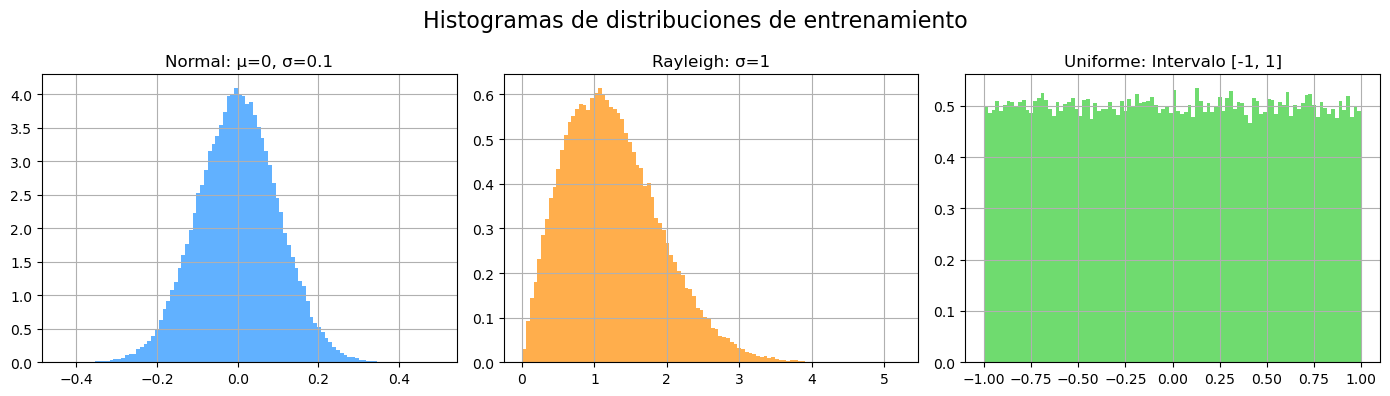

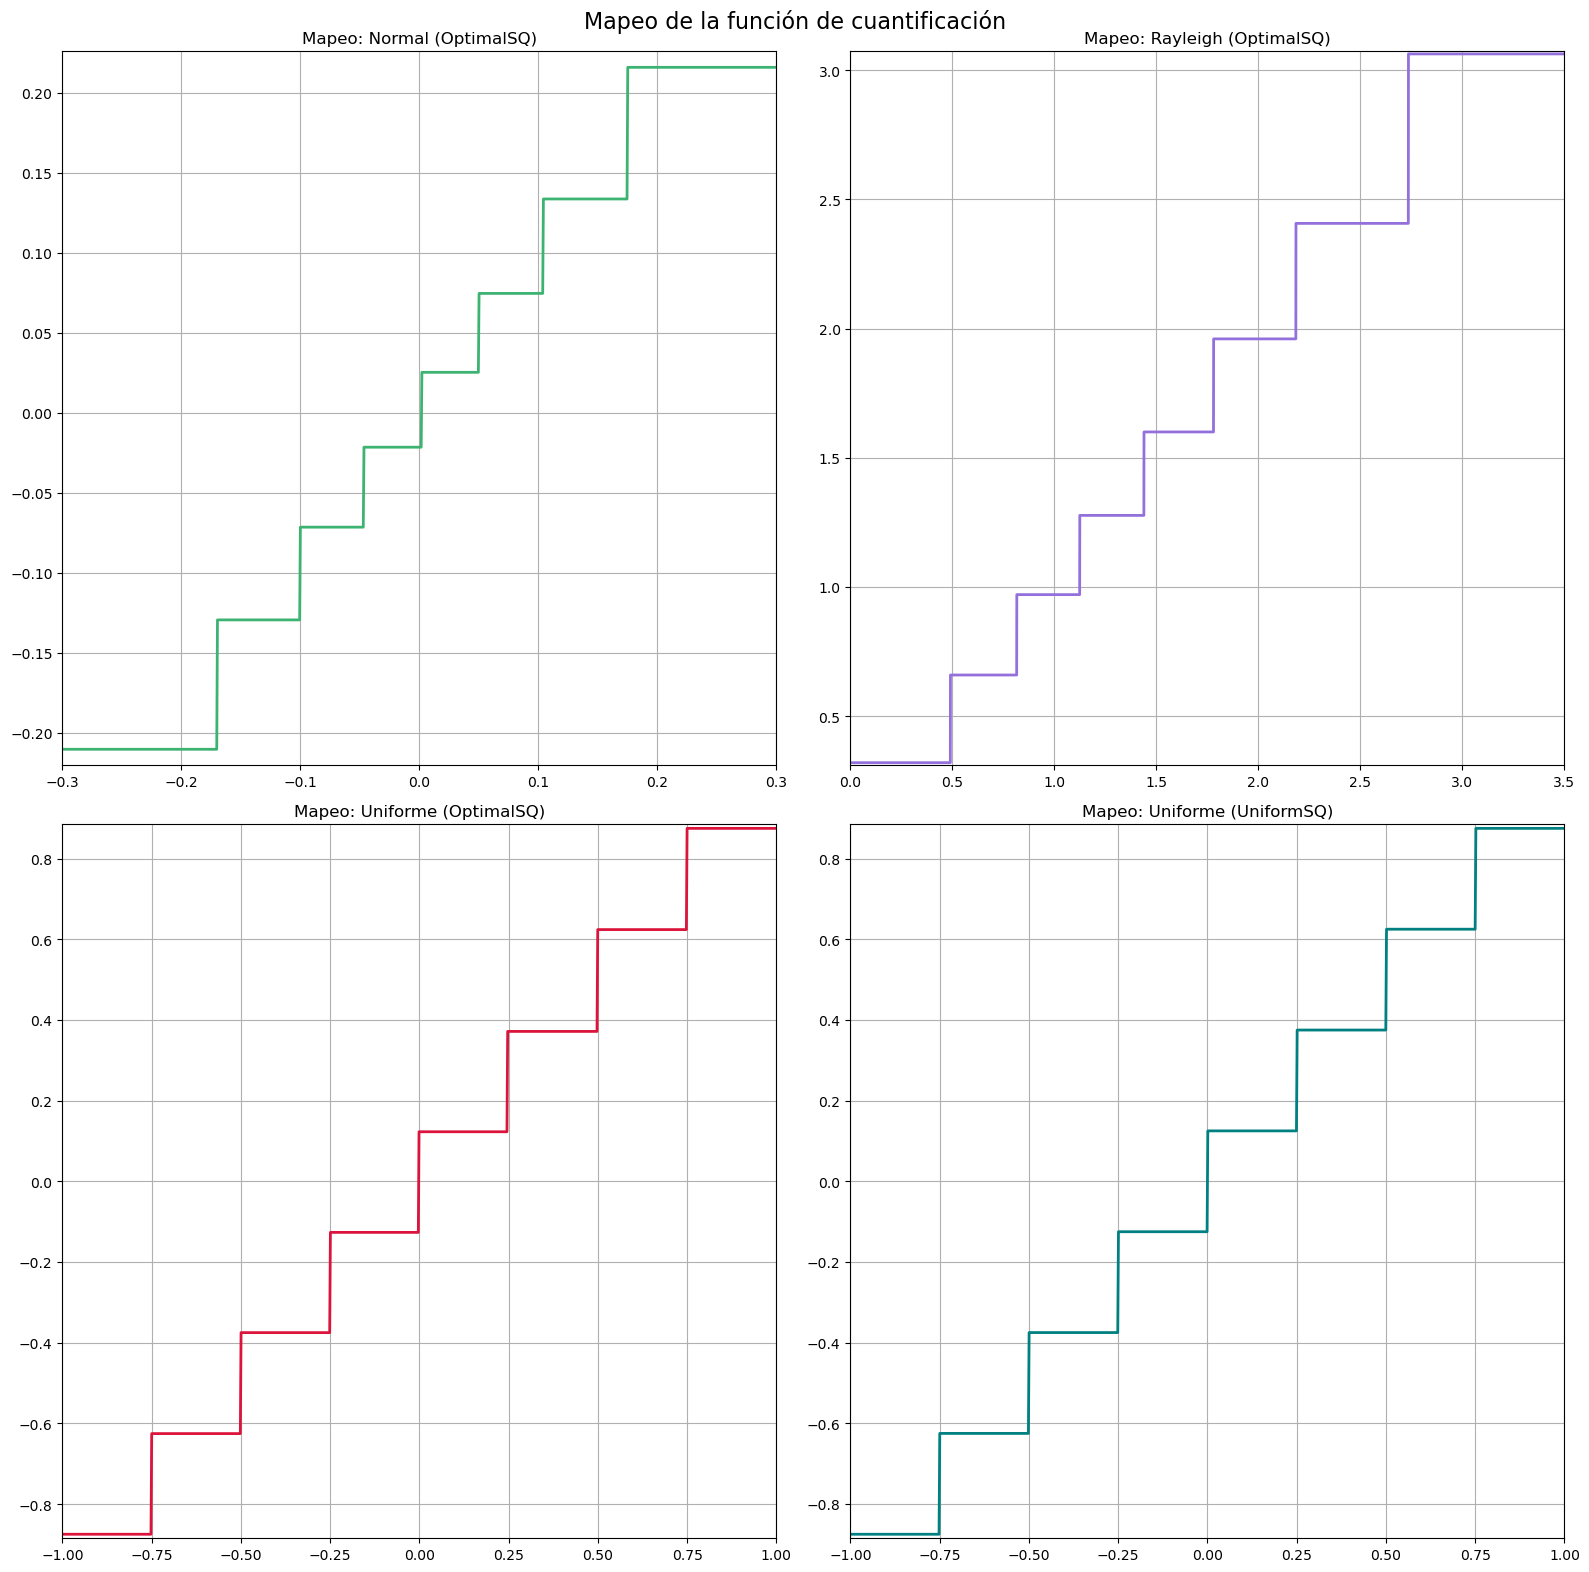

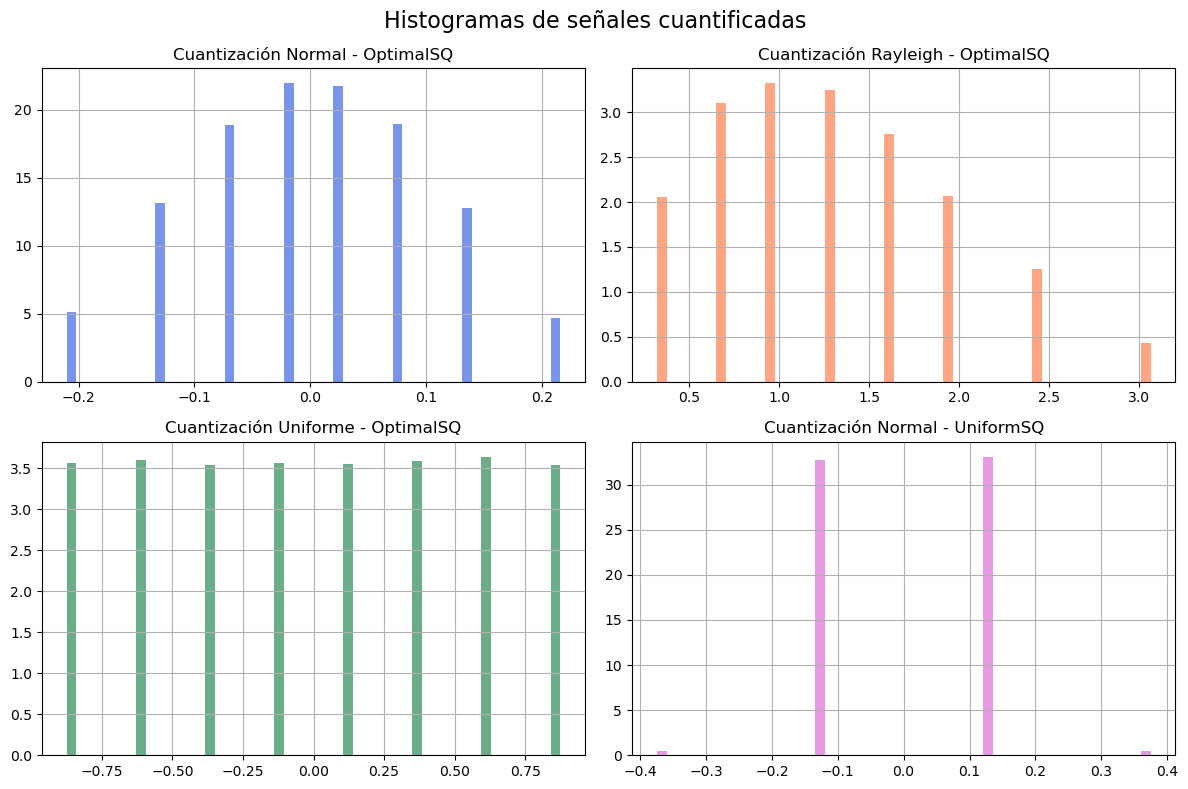

In [14]:

#! [CONFIGURACION INICIAL]
#? =============================================================================
#? CONFIGURACIÓN Y DEFINICIÓN DE PARÁMETROS
#? =============================================================================
b = 3  # Tasa de bits por muestra

#! [GENERACIÓN DE DATOS DE ENTRENAMIENTO]
#? =============================================================================
#? GENERAR 100000 MUESTRAS CON DISTRIBUCIONES DIVERSAS
#? -----------------------------------------------------------------------------
# NOTE: Se utilizan las funciones de numpy.random para generar el conjunto de
#       entrenamiento de acuerdo con:
#
#  • Distribución Normal (media = 0, σ = 0.1)
#  • Distribución Rayleigh (parámetro σ = 1)
#  • Distribución Uniforme (entre -1 y 1)
#? =============================================================================
x_normal   = np.random.normal(0, 0.1, 100000)
x_rayleigh = np.random.rayleigh(1, 100000)
x_uniforme = np.random.uniform(-1, 1, 100000)

#! [CONSTRUCCIÓN DE CUANTIFICADORES]
#? =============================================================================
#? CONSTRUCCIÓN DE LOS CUANTIFICADORES ESCALARES ÓPTIMOS
#? -----------------------------------------------------------------------------
# NOTE: Se crean tres cuantificadores óptimos adaptados a la PDF usando la clase
#       OptimalSQ y el algoritmo de inicialización lbg, y se construye además un
#       cuantificador uniforme (UniformSQ) para la comparación.
#? =============================================================================
qtz_opt_normal   = sc.OptimalSQ(b, x_normal,   algorithm=lbg)
qtz_opt_rayleigh = sc.OptimalSQ(b, x_rayleigh, algorithm=lbg)
qtz_opt_uniforme = sc.OptimalSQ(b, x_uniforme, algorithm=lbg)

qtz_uniforme = sc.UniformSQ(b, [-1, 1], qtype='midrise')

#! [CUANTIZACIÓN DE DATOS]
#? =============================================================================
#? CUANTIZACIÓN DE LAS MUESTRAS DE ENTRENAMIENTO CON CADA CUANTIFICADOR
#? -----------------------------------------------------------------------------
# Se cuantifica cada conjunto de datos con el correspondiente cuantificador.
#? =============================================================================
x_qtz_normal       = qtz_opt_normal.quantize(x_normal)
x_qtz_rayleigh     = qtz_opt_rayleigh.quantize(x_rayleigh)
x_qtz_opt_uniforme = qtz_opt_uniforme.quantize(x_uniforme)
# NOTE: Se cuantifica x_normal también con el cuantificador uniforme para comparar
x_qtz_uniforme     = qtz_uniforme.quantize(x_normal)

#! [EXTRACCIÓN DE NIVELES Y DIFERENCIAS]
#? =============================================================================
#? OBTENCIÓN DE LOS NIVELES DE CUANTIFICACIÓN Y CÁLCULO DE INTERVALOS
#? -----------------------------------------------------------------------------
# Los cuantificadores almacenan sus niveles en el atributo 'C'. Se usa numpy.diff
# para conocer la separación entre cada par de niveles.
#? =============================================================================
niveles_q_opt_normal   = qtz_opt_normal.C
niveles_q_opt_rayleigh = qtz_opt_rayleigh.C
niveles_q_opt_uniforme = qtz_opt_uniforme.C
niveles_q_uniform      = qtz_uniforme.C

d_normal   = np.diff(niveles_q_opt_normal)
d_rayleigh = np.diff(niveles_q_opt_rayleigh)
d_uniforme = np.diff(niveles_q_opt_uniforme)
d_qtz      = np.diff(niveles_q_uniform)

#! [TABLA DE DIFERENCIAS ENTRE NIVELES]
#? =============================================================================
#? (OPCIONAL) VISUALIZAR LAS DIFERENCIAS ENTRE LOS NIVELES DE CUANTIFICACIÓN
#? -----------------------------------------------------------------------------
# TODO: Para una visualización interactiva se puede usar ace_tools.
#? =============================================================================
# df = pd.DataFrame({
#     'Normal – OptimalSQ': d_normal,
#     'Rayleigh – OptimalSQ': d_rayleigh,
#     'Uniforme – OptimalSQ': d_uniforme,
#     'Uniforme – UniformSQ': d_qtz
# })
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Diferencias entre niveles", dataframe=df)

#! [GRÁFICAS: HISTOGRAMAS DE LOS DATOS DE ENTRENAMIENTO]
#? =============================================================================
#? VISUALIZACIÓN DE LAS DISTRIBUCIONES DE LOS DATOS DE ENTRENAMIENTO
#? -----------------------------------------------------------------------------
# Se muestran histogramas para las tres distribuciones, incluyendo detalles de
# sus parámetros.
#? =============================================================================
fig, ax = plt.subplots(1, 3, figsize=(14, 4), layout='tight')
fig.suptitle("Histogramas de distribuciones de entrenamiento", fontsize=16)

# Histograma de distribución Normal (μ=0, σ=0.1)
ax[0].hist(x_normal, bins=100, density=True, alpha=0.7, color='dodgerblue')
ax[0].set_title("Normal: μ=0, σ=0.1")
ax[0].grid()

# Histograma de distribución Rayleigh (σ=1)
ax[1].hist(x_rayleigh, bins=100, density=True, alpha=0.7, color='darkorange')
ax[1].set_title("Rayleigh: σ=1")
ax[1].grid()

# Histograma de distribución Uniforme (entre -1 y 1)
ax[2].hist(x_uniforme, bins=100, density=True, alpha=0.7, color='limegreen')
ax[2].set_title("Uniforme: Intervalo [-1, 1]")
ax[2].grid()

plt.show()

#! [FUNCIONES DE CUANTIFICACIÓN: ENTRADA VS SALIDA]
#? =============================================================================
#? REPRESENTACIÓN DEL MAPEO ENTRE ENTRADA Y SALIDA DE CUANTIFICACIÓN
#? -----------------------------------------------------------------------------
# Se define un rango de entradas para cada distribución y se grafica la función de
# cuantificación resultante para observar cómo se adaptan los cuantificadores a la PDF.
#? =============================================================================
# Rangos de entrada para cada distribución
x_0 = np.linspace(-0.3, 0.3, 1000)    # Para la distribución Normal
x_1 = np.linspace(0, 3.5, 10000)        # Para la distribución Rayleigh
x_2 = np.linspace(-1, 1, 1000)          # Para la distribución Uniforme

# Cuantificación de los valores de entrada
y_0 = qtz_opt_normal.quantize(x_0)
y_1 = qtz_opt_rayleigh.quantize(x_1)
y_2 = qtz_opt_uniforme.quantize(x_2)
y_3 = qtz_uniforme.quantize(x_2)

margen = 0.01  # Margen para ajustar los límites en las gráficas

# Creación de la figura con 4 subgráficas
fig, ax = plt.subplots(2, 2, figsize=(16, 16), layout='tight')
fig.suptitle("Mapeo de la función de cuantificación", fontsize=16)

# Mapeo para la distribución Normal
ax[0, 0].plot(x_0, y_0, lw=2, color='mediumseagreen')
ax[0, 0].set_title('Mapeo: Normal (OptimalSQ)')
ax[0, 0].grid(True)
ax[0, 0].set_xlim(np.min(x_0), np.max(x_0))
ax[0, 0].set_ylim(np.min(y_0) - margen, np.max(y_0) + margen)

# Mapeo para la distribución Rayleigh
ax[0, 1].plot(x_1, y_1, lw=2, color='mediumpurple')
ax[0, 1].set_title('Mapeo: Rayleigh (OptimalSQ)')
ax[0, 1].grid(True)
ax[0, 1].set_xlim(np.min(x_1), np.max(x_1))
ax[0, 1].set_ylim(np.min(y_1) - margen, np.max(y_1) + margen)

# Mapeo para la distribución Uniforme usando OptimalSQ
ax[1, 0].plot(x_2, y_2, lw=2, color='crimson')
ax[1, 0].set_title('Mapeo: Uniforme (OptimalSQ)')
ax[1, 0].grid(True)
ax[1, 0].set_xlim(np.min(x_2), np.max(x_2))
ax[1, 0].set_ylim(np.min(y_2) - margen, np.max(y_2) + margen)

# Mapeo para la distribución Uniforme usando UniformSQ
ax[1, 1].plot(x_2, y_3, lw=2, color='teal')
ax[1, 1].set_title('Mapeo: Uniforme (UniformSQ)')
ax[1, 1].grid(True)
ax[1, 1].set_xlim(np.min(x_2), np.max(x_2))
ax[1, 1].set_ylim(np.min(y_3) - margen, np.max(y_3) + margen)

plt.show()

#! [VISUALIZACIÓN: HISTOGRAMA DE SEÑALES CUANTIFICADAS]
#? =============================================================================
#? VISUALIZACIÓN DE LAS SEÑALES CUANTIFICADAS
#? -----------------------------------------------------------------------------
# NOTE: Se muestran histogramas de las señales cuantificadas para evaluar cómo se adaptan
#       los cuantificadores a la PDF de la señal.
#? =============================================================================
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Histogramas de señales cuantificadas", fontsize=16)

# Histograma de señal cuantificada para distribución Normal (OptimalSQ)
axs[0, 0].hist(x_qtz_normal, bins=50, color='royalblue', alpha=0.7, density=True)
axs[0, 0].set_title("Cuantización Normal - OptimalSQ")
axs[0, 0].grid(True)

# Histograma de señal cuantificada para distribución Rayleigh (OptimalSQ)
axs[0, 1].hist(x_qtz_rayleigh, bins=50, color='coral', alpha=0.7, density=True)
axs[0, 1].set_title("Cuantización Rayleigh - OptimalSQ")
axs[0, 1].grid(True)

# Histograma de señal cuantificada para distribución Uniforme (OptimalSQ)
axs[1, 0].hist(x_qtz_opt_uniforme, bins=50, color='seagreen', alpha=0.7, density=True)
axs[1, 0].set_title("Cuantización Uniforme - OptimalSQ")
axs[1, 0].grid(True)

# Histograma de señal cuantificada: Normal con cuantificador UniformSQ
axs[1, 1].hist(x_qtz_uniforme, bins=50, color='orchid', alpha=0.7, density=True)
axs[1, 1].set_title("Cuantización Normal - UniformSQ")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 3</h1>

<hr style="border: 1.5px solid orange;">

Construya un cuantificador escalar óptimo para señales de voz con una tasa de **4 bits/muestra**.

Use las señales almacenadas en `ciudad.wav`, `mar.wav`, `rio.wav` y `santander.wav` concatenadas una tras otra como conjunto de entrenamiento.

A continuación, cuantifique la señal almacenada en `altura.wav`. Reproduzca la señal cuantificada y calcule su **SNR**. 

Repita el análisis usando un cuantificador con tasas de **6 y 8 bits/muestra**.

Analice los resultados en términos de **SNR** y **calidad percibida**, comparándolos con los obtenidos usando cuantificadores **uniformes** con la misma tasa de bits.

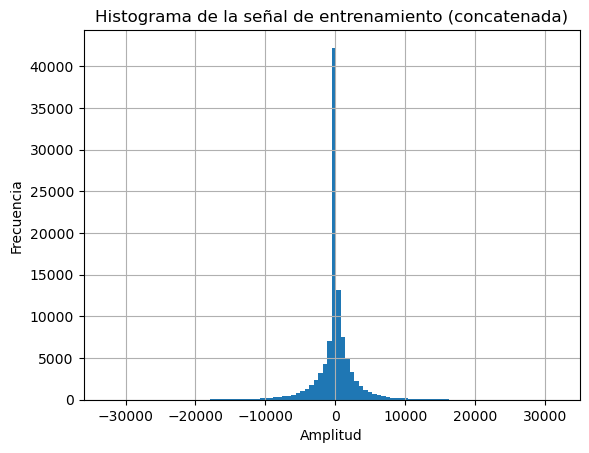

--- Tasa de bits: 4 bits/muestra ---
SNR Cuantificador Óptimo:    17.24 dB
SNR Cuantificador Uniforme: 10.53 dB



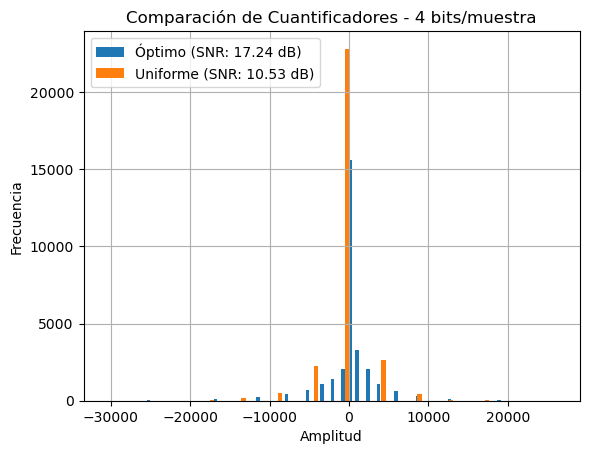

--- Tasa de bits: 6 bits/muestra ---
SNR Cuantificador Óptimo:    28.61 dB
SNR Cuantificador Uniforme: 21.55 dB



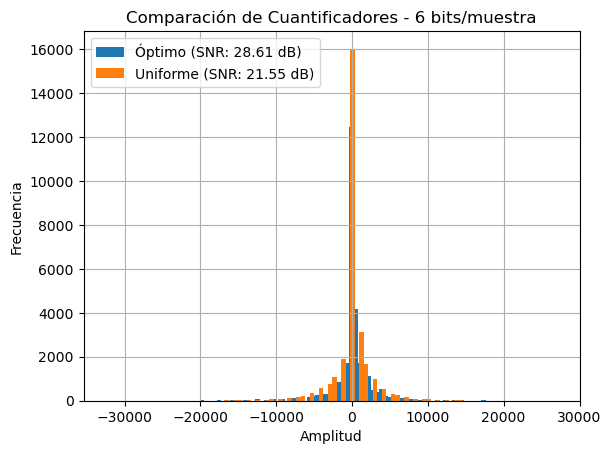

--- Tasa de bits: 8 bits/muestra ---
SNR Cuantificador Óptimo:    40.61 dB
SNR Cuantificador Uniforme: 32.83 dB



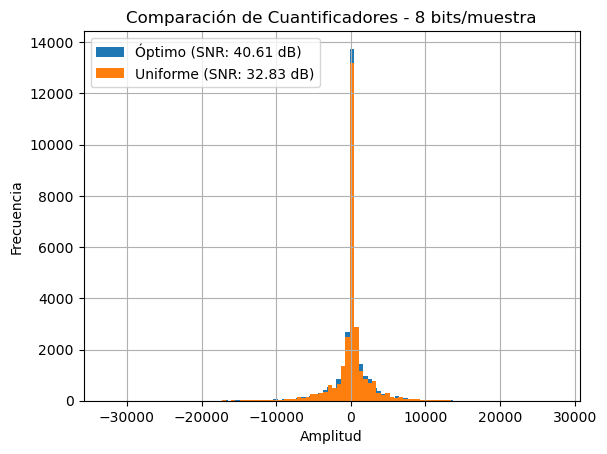

In [18]:



#? =============================================================================
#? CARGA DE SEÑALES
#? =============================================================================
fs, audio_ciudad = wf.read('Datos/ciudad.wav')
_, audio_mar = wf.read('Datos/mar.wav')
_, audio_rio = wf.read('Datos/rio.wav')
_, audio_santander = wf.read('Datos/santander.wav')
_, audio_altura = wf.read('Datos/Altura.wav')

#? =============================================================================
#? CONCATENACIÓN DE SEÑALES PARA ENTRENAMIENTO
#? =============================================================================
entrenamiento_audio = np.concatenate(
    (audio_ciudad, audio_mar, audio_rio, audio_santander)
)

#? =============================================================================
#? HISTOGRAMA DEL AUDIO DE ENTRENAMIENTO
#? =============================================================================
plt.figure()
plt.hist(entrenamiento_audio, bins=100)
plt.title('Histograma de la señal de entrenamiento (concatenada)')
plt.xlabel('Amplitud')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#? =============================================================================
#? ANÁLISIS CON DIFERENTES TASAS DE BITS
#? =============================================================================
tasas_bits = [4, 6, 8]
rango_audio = sc.signalRange(entrenamiento_audio)

for b in tasas_bits:
    # Construcción del cuantificador óptimo (Lloyd-Max adaptado a PDF)
    cuantificador_opt = sc.OptimalSQ(b, entrenamiento_audio)
    audio_altura_opt = cuantificador_opt.quantize(audio_altura)
    snr_opt = sc.snr(audio_altura_opt, audio_altura)

    # Construcción del cuantificador uniforme (señales con muchos ceros => midtread)
    cuantificador_unif = sc.UniformSQ(b, rango_audio, qtype='midtread')
    audio_altura_unif = cuantificador_unif.quantize(audio_altura)
    snr_unif = sc.snr(audio_altura_unif, audio_altura)

    print(f'--- Tasa de bits: {b} bits/muestra ---')
    print(f'SNR Cuantificador Óptimo:    {snr_opt:.2f} dB')
    print(f'SNR Cuantificador Uniforme: {snr_unif:.2f} dB')
    print()

    # Gráfica comparativa de histogramas
    plt.figure()
    plt.hist(audio_altura_opt, bins=100, label=f'Óptimo (SNR: {snr_opt:.2f} dB)')
    plt.hist(audio_altura_unif, bins=100, label=f'Uniforme (SNR: {snr_unif:.2f} dB)')
    plt.title(f'Comparación de Cuantificadores - {b} bits/muestra')
    plt.xlabel('Amplitud')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()

    #(Opcional) Reproducir audio para comparar la calidad subjetiva
    sd.play(audio_altura_opt, fs)
    sd.wait()
    sd.play(audio_altura_unif, fs)
    sd.wait()


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 4</h1>

<hr style="border: 1.5px solid orange;">

Construya un cuantificador escalar óptimo para imágenes con una tasa de **4 bits/muestra**. 

Use las imágenes almacenadas en `caravana.png`, `maiz.png`, `fresas.png` y `oficina.png` concatenadas una tras otra como conjunto de entrenamiento.

A continuación, cuantifique la imagen almacenada en `lena.png`. Represente la imagen cuantificada y calcule su **SNR**. 

Repita el análisis usando un cuantificador con una tasa de **6 bits/muestra**.

Analice los resultados en términos de **SNR** y **calidad percibida**, comparándolos con los obtenidos usando **cuantificadores uniformes** con la misma tasa de bits.

--- Tasa de bits: 4 bits/píxel ---
SNR Cuantificador Óptimo: 27.83 dB
SNR Cuantificador Uniforme: 26.57 dB



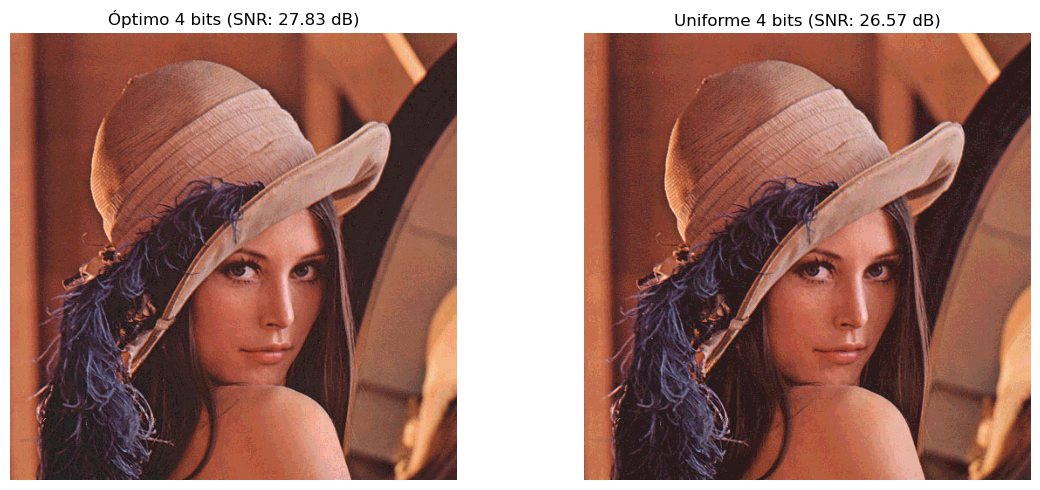

--- Tasa de bits: 6 bits/píxel ---
SNR Cuantificador Óptimo: 38.69 dB
SNR Cuantificador Uniforme: 38.74 dB



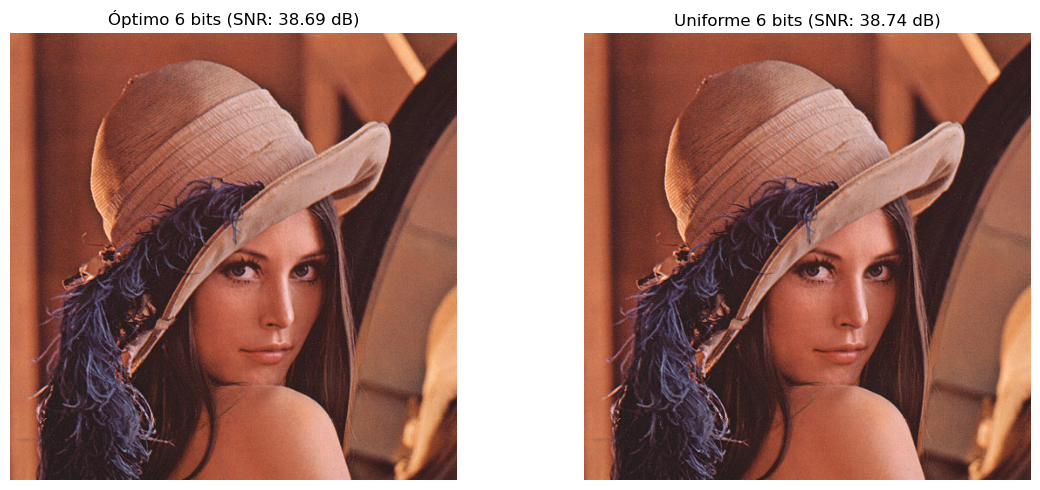

In [20]:


#? -------------------------------------------------------------------------
#! CARGA DE IMÁGENES
#  NOTE: Se leen las imágenes de entrenamiento y la imagen de prueba.
#? -------------------------------------------------------------------------
caravana = io.imread('Datos/caravana.png')
maiz = io.imread('Datos/maiz.png')
fresas = io.imread('Datos/fresas.png')
oficina = io.imread('Datos/oficina.png')
lena = io.imread('Datos/lena.png')

#? -------------------------------------------------------------------------
#! CONSTRUCCIÓN DEL CONJUNTO DE ENTRENAMIENTO
#! DETERMINACIÓN DEL RANGO DE LA SEÑAL
#! DEFINICIÓN DE LAS TASAS DE BITS A ANALIZAR
#? -------------------------------------------------------------------------
entrenamiento = np.concatenate((caravana, maiz, fresas, oficina))

rango_imagenes = sc.signalRange(entrenamiento)

tasas_bits = [4, 6]

#? -------------------------------------------------------------------------
#! PROCESAMIENTO Y ANÁLISIS
#  NOTE: Para cada tasa de bits se construyen dos cuantificadores:
#       - Óptimo, utilizando el algoritmo de Lloyd–Max inicializado con LBG.
#       - Uniforme, basado en el método midtread.
#       Se cuantifica la imagen de Lena y se calcula la SNR para comparar los resultados.
#? -------------------------------------------------------------------------
for b in tasas_bits:
    # Construcción del cuantificador óptimo
    cuantificador_opt = sc.OptimalSQ(b, entrenamiento, algorithm=lbg)
    lena_cuant_opt = cuantificador_opt.quantize(lena)
    snr_opt = sc.snr(lena_cuant_opt, lena)
    
    # Construcción del cuantificador uniforme (midtread)
    cuantificador_unif = sc.UniformSQ(b, rango_imagenes, qtype='midtread')
    lena_cuant_unif = cuantificador_unif.quantize(lena)
    snr_unif = sc.snr(lena_cuant_unif, lena)
    
    #? ---------------------------------------------------------------------
    #? MOSTRAR RESULTADOS
    #? Se imprimen las métricas SNR y se visualizan las imágenes cuantificadas.
    #? ---------------------------------------------------------------------
    print(f'--- Tasa de bits: {b} bits/píxel ---')
    print(f'SNR Cuantificador Óptimo: {snr_opt:.2f} dB')
    print(f'SNR Cuantificador Uniforme: {snr_unif:.2f} dB\n')
    
    plt.figure(figsize=(12, 5))
    
    # Imagen cuantificada con el cuantificador óptimo
    plt.subplot(1, 2, 1)
    plt.imshow(lena_cuant_opt)
    plt.title(f'Óptimo {b} bits (SNR: {snr_opt:.2f} dB)')
    plt.axis('off')
    
    # Imagen cuantificada con el cuantificador uniforme
    plt.subplot(1, 2, 2)
    plt.imshow(lena_cuant_unif)
    plt.title(f'Uniforme {b} bits (SNR: {snr_unif:.2f} dB)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 5</h1>

<hr style="border: 1.5px solid orange;">


Construya un **cuantificador vectorial óptimo** para imágenes con una tasa de **4 bits/palabra**. 

Use las imágenes almacenadas en `caravana.png`, `maiz.png`, `fresas.png` y `oficina.png` concatenadas una tras otra como conjunto de entrenamiento.

A continuación, cuantifique la imagen almacenada en `lena.png`. Represente la imagen cuantificada y calcule su **SNR** y **tasa de bits por muestra, R**.

Repita el análisis usando un cuantificador con tasas de **6 y 8 bits por bloque** y tamaños de bloque, `N`, de **4, 16 y 64**.

Analice los resultados en términos de **tasa de bits**, **SNR** y **calidad percibida**, comparándolos con los obtenidos usando **cuantificadores escalares**.

In [ ]:


#? -------------------------------------------------------------------------
#? CONSTRUCCIÓN DEL CONJUNTO DE ENTRENAMIENTO
#? -------------------------------------------------------------------------
imagenes_entrenamiento = np.concatenate((caravana, maiz, fresas, oficina))

#? -------------------------------------------------------------------------
#? CONFIGURACIÓN DE PARÁMETROS
#  NOTE: Se definen las tasas de bits por bloque y los tamaños de bloque a analizar.
#        Para este ejercicio, se experimenta con cuantificadores vectoriales para 6 y 8 bits por bloque,
#        utilizando bloques de 2x2, 4x4 y 8x8 (equivalentes a 4, 16 y 64 píxeles por bloque).
#? -------------------------------------------------------------------------
tasas_bits = [6, 8]
step_vector = [2, 4, 8]

#? -------------------------------------------------------------------------
#? PROCESAMIENTO Y ANÁLISIS
#  NOTE: Para cada tasa de bits y cada tamaño de bloque se construye:
#        - Un cuantificador vectorial óptimo utilizando la función LBG para la inicialización.
#        - Un cuantificador escalar uniforme (midtread) para comparar la tasa efectiva.
#        Se cuantifica la imagen Lena y se calculan la SNR y la tasa efectiva en bits/píxel.
#? -------------------------------------------------------------------------
for b in tasas_bits:
    for step in step_vector:
        # Calcular el número de píxeles por bloque (N)
        N = step * step  # Por ejemplo, 2x2 -> 4, 4x4 -> 16, 8x8 -> 64
        # Dividir la imagen de entrenamiento en bloques de tamaño (step x step)
        bloques_entrenamiento = sc.partitionImage(imagenes_entrenamiento, step, step)
        # Construir el cuantificador vectorial óptimo usando el algoritmo LBG
        cuantificador_opt = sc.OptimalVQ(b, bloques_entrenamiento, algorithm=lbg)
    
        # Dividir la imagen Lena en bloques y cuantificarla con el cuantificador vectorial
        bloques_lena = sc.partitionImage(lena, step, step)
        bloques_lena_cuantificada = cuantificador_opt.quantize(bloques_lena)
        lena_cuantificada_opt = sc.composeImage(bloques_lena_cuantificada, step, step, lena.shape)
    
        # Calcular la tasa efectiva (bits/píxel) para el cuantificador vectorial
        # Se asume que la tasa por bloque es b bits, por lo que la tasa por píxel R = b/N
        R = b / N
        # Determinar el número de niveles para el cuantificador escalar basado en la tasa efectiva
        niveles = int(2 ** R) if R >= 1 else 2
        # Obtener el rango de la señal de las imágenes de entrenamiento (necesario para UniformSQ)
        rango_imagen = sc.signalRange(imagenes_entrenamiento)
        # Construir el cuantificador uniforme (midtread) con el número de niveles calculado
        cuantificador_unif = sc.UniformSQ(niveles, rango_imagen, qtype='midtread')
    
        # Cuantificar la imagen Lena usando el cuantificador uniforme escalar
        lena_cuantificada_unif = cuantificador_unif.quantize(lena)
    
        # Calcular la SNR para ambos métodos
        snr_opt = sc.snr(lena_cuantificada_opt, lena)
        snr_unif = sc.snr(lena_cuantificada_unif, lena)
    
        #? ---------------------------------------------------------------------
        #? MOSTRAR RESULTADOS
        #  NOTE: Se imprime la tasa de bits por bloque, la tasa efectiva en bits/píxel, y la SNR obtenida
        #       para el cuantificador vectorial óptimo y el cuantificador uniforme.
        #? ---------------------------------------------------------------------
        print(f'--- Tasa de bits por bloque: {b} bits ---')
        print(f'Tasa efectiva por píxel: {R:.4f} bits/píxel')
        print(f'SNR Cuantificador VQ Óptimo: {snr_opt:.2f} dB')
        print(f'SNR Cuantificador Uniforme:  {snr_unif:.2f} dB\n')
    
        #? ---------------------------------------------------------------------
        #? REPRESENTAR RESULTADOS GRÁFICOS
        #  NOTE: Se visualizan las imágenes cuantificadas mediante el cuantificador vectorial óptimo
        #        y el cuantificador uniforme, permitiendo una comparación visual de la calidad percibida.
        #? ---------------------------------------------------------------------
        plt.figure(figsize=(14, 5))
    
        plt.subplot(1, 2, 1)
        plt.imshow(lena_cuantificada_opt)
        plt.title(f'Cuantificador VQ Óptimo\n{b} bits/bloque (SNR: {snr_opt:.2f} dB)')
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow(lena_cuantificada_unif)
        plt.title(f'Cuantificador Uniforme Escalar\n{R:.4f} bits/píxel (SNR: {snr_unif:.2f} dB)')
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()

In [ ]:



#? -------------------------------------------------------------------------
#? CONSTRUCCIÓN DEL CONJUNTO DE ENTRENAMIENTO
#? Se concatenan las imágenes de entrenamiento para formar una única imagen.
#? -------------------------------------------------------------------------
imagenes_entrenamiento = np.concatenate((caravana, maiz, fresas, oficina))

#? -------------------------------------------------------------------------
#? CONFIGURACIÓN DE PARÁMETROS
#? Para reducir significativamente el tiempo de procesamiento, se utiliza un único
#? tamaño de bloque (4x4 píxeles) en lugar de iterar sobre varios tamaños.
#? Además, se limitan las tasas de bits a 6 y 8 bits por bloque.
#? -------------------------------------------------------------------------
step = 4  # Bloque de 4x4 (16 píxeles)
tasas_bits = [6, 8]

#? -------------------------------------------------------------------------
#? PRE-CÁLCULO DE DATOS COMUNES
#? Se calculan los bloques del conjunto de entrenamiento y el rango de señal una sola vez.
#? -------------------------------------------------------------------------
bloques_entrenamiento = sc.partitionImage(imagenes_entrenamiento, step, step)
rango_imagen = sc.signalRange(imagenes_entrenamiento)

#? -------------------------------------------------------------------------
#? PROCESAMIENTO Y ANÁLISIS
#? Se procesa la imagen de Lena usando cuantificadores vectorial óptimo y
#? escalar uniforme para cada tasa de bits seleccionada.
#? -------------------------------------------------------------------------
for b in tasas_bits:
    # Construcción del cuantificador vectorial óptimo utilizando el algoritmo LBG
    cuantificador_opt = sc.OptimalVQ(b, bloques_entrenamiento, algorithm=lbg)
    bloques_lena = sc.partitionImage(lena, step, step)
    bloques_lena_cuantificada = cuantificador_opt.quantize(bloques_lena)
    lena_cuantificada_opt = sc.composeImage(bloques_lena_cuantificada, step, step, lena.shape)
    
    # Cálculo de la tasa efectiva (bits/píxel)
    N = step * step  # Número de píxeles por bloque (16)
    R = b / N       # Tasa efectiva en bits/píxel
    
    # Construcción del cuantificador uniforme (mid-tread) para comparación,
    # utilizando el número de niveles derivado de la tasa efectiva.
    niveles = int(2 ** R) if R >= 1 else 2
    cuantificador_unif = sc.UniformSQ(niveles, rango_imagen, qtype='midtread')
    lena_cuantificada_unif = cuantificador_unif.quantize(lena)
    
    # Cálculo de la SNR para ambos métodos
    snr_opt = sc.snr(lena_cuantificada_opt, lena)
    snr_unif = sc.snr(lena_cuantificada_unif, lena)
    
    #? ---------------------------------------------------------------------
    #? MOSTRAR RESULTADOS
    #? Se imprime la tasa de bits por bloque, la tasa efectiva en bits/píxel, y la SNR
    #? para el cuantificador vectorial óptimo y el cuantificador uniforme.
    #? ---------------------------------------------------------------------
    print(f'--- Tasa de bits por bloque: {b} bits ---')
    print(f'Tasa efectiva por píxel: {R:.4f} bits/píxel')
    print(f'SNR Cuantificador VQ Óptimo: {snr_opt:.2f} dB')
    print(f'SNR Cuantificador Uniforme:  {snr_unif:.2f} dB\n')
    
    #? ---------------------------------------------------------------------
    #? REPRESENTAR RESULTADOS GRÁFICOS
    #? Se visualizan las imágenes cuantificadas para comparar la calidad percibida.
    #? ---------------------------------------------------------------------
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(lena_cuantificada_opt)
    plt.title(f'VQ Óptimo {b} bits/bloque (SNR: {snr_opt:.2f} dB)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(lena_cuantificada_unif)
    plt.title(f'Uniforme {R:.4f} bits/píxel (SNR: {snr_unif:.2f} dB)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
